# Import Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc
)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

# Load Data

In [8]:
# Load and explore the credit card fraud dataset
print("Credit Card Fraud Detection Analysis")
print("------------------------------------")

# Load the dataset
print("Loading data from creditcard.csv...")
df = pd.read_csv('creditcard.csv')

print(f"Dataset shape: {df.shape}")
print(f"Number of fraudulent transactions: {df['Class'].sum()}")
print(f"Fraud percentage: {df['Class'].mean() * 100:.4f}%")

# Display first few rows
df.head()

Credit Card Fraud Detection Analysis
------------------------------------
Loading data from creditcard.csv...
Dataset shape: (284807, 31)
Number of fraudulent transactions: 492
Fraud percentage: 0.1727%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Explore Data Distribution

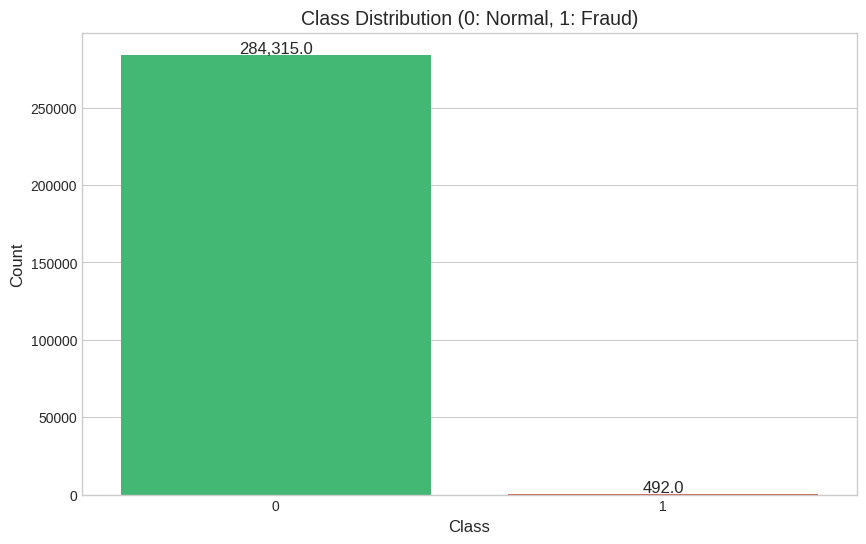


Class Distribution Percentage:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


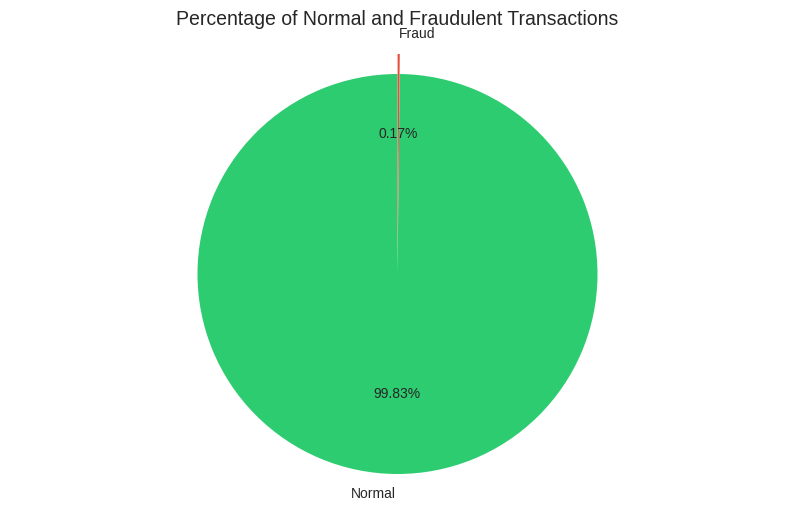

In [9]:
# Explore class distribution
plt.figure(figsize=(10, 6))

# Count plot of fraud vs normal transactions
ax = sns.countplot(x='Class', data=df, palette=['#2ecc71', '#e74c3c'])
plt.title('Class Distribution (0: Normal, 1: Fraud)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 1000, f'{height:,}', 
            ha='center', fontsize=12)

plt.show()

# Display percentage
print("\nClass Distribution Percentage:")
class_counts = df['Class'].value_counts(normalize=True) * 100
print(class_counts)

# Plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(class_counts, labels=['Normal', 'Fraud'], autopct='%1.2f%%', 
        colors=['#2ecc71', '#e74c3c'], startangle=90, explode=[0, 0.1])
plt.title('Percentage of Normal and Fraudulent Transactions', fontsize=14)
plt.axis('equal')
plt.show()

# Explore Transaction Amounts

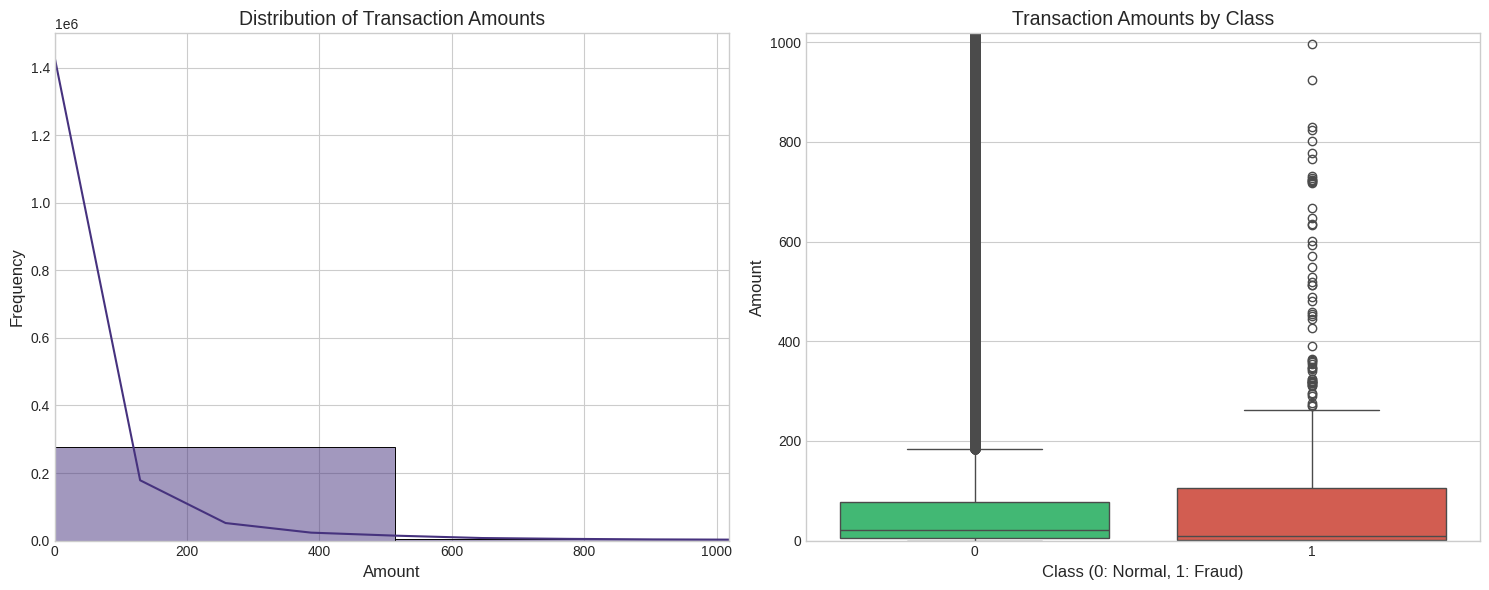


Transaction Amount Statistics by Class:
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87


In [12]:
# Analyse transaction amounts
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Distribution of transaction amounts
sns.histplot(data=df, x='Amount', ax=ax[0], bins=50, kde=True)
ax[0].set_title('Distribution of Transaction Amounts', fontsize=14)
ax[0].set_xlabel('Amount', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)
ax[0].set_xlim(0, df['Amount'].quantile(0.99))  # Limit x-axis to 99th percentile

# Compare amounts by class
sns.boxplot(x='Class', y='Amount', data=df, ax=ax[1], palette=['#2ecc71', '#e74c3c'])
ax[1].set_title('Transaction Amounts by Class', fontsize=14)
ax[1].set_xlabel('Class (0: Normal, 1: Fraud)', fontsize=12)
ax[1].set_ylabel('Amount', fontsize=12)
ax[1].set_ylim(0, df['Amount'].quantile(0.99))

plt.tight_layout()
plt.show()

# Show summary statistics by class
print("\nTransaction Amount Statistics by Class:")
print(df.groupby('Class')['Amount'].describe())

# Preprocess Data

In [13]:
# Preprocess data for modelling
def preprocess_data(df):
    """Preprocess the data for modelling."""
    print("\nPreprocessing data...")
    
    # Scale Time and Amount features
    scaler = StandardScaler()
    df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
    df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
    
    # Drop original Time and Amount columns
    df = df.drop(['Time', 'Amount'], axis=1)
    
    # Separate features and target
    X = df.drop('Class', axis=1)
    y = df['Class']
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

# Execute the preprocessing
X_train, X_test, y_train, y_test = preprocess_data(df)


Preprocessing data...
Training set shape: (227845, 30)
Testing set shape: (56962, 30)


# Handle Class Imbalance


Applying SMOTE to handle class imbalance...
Original training set shape: (227845, 30)
Resampled training set shape: (250196, 30)
Original fraud percentage: 0.17%
Resampled fraud percentage: 9.09%


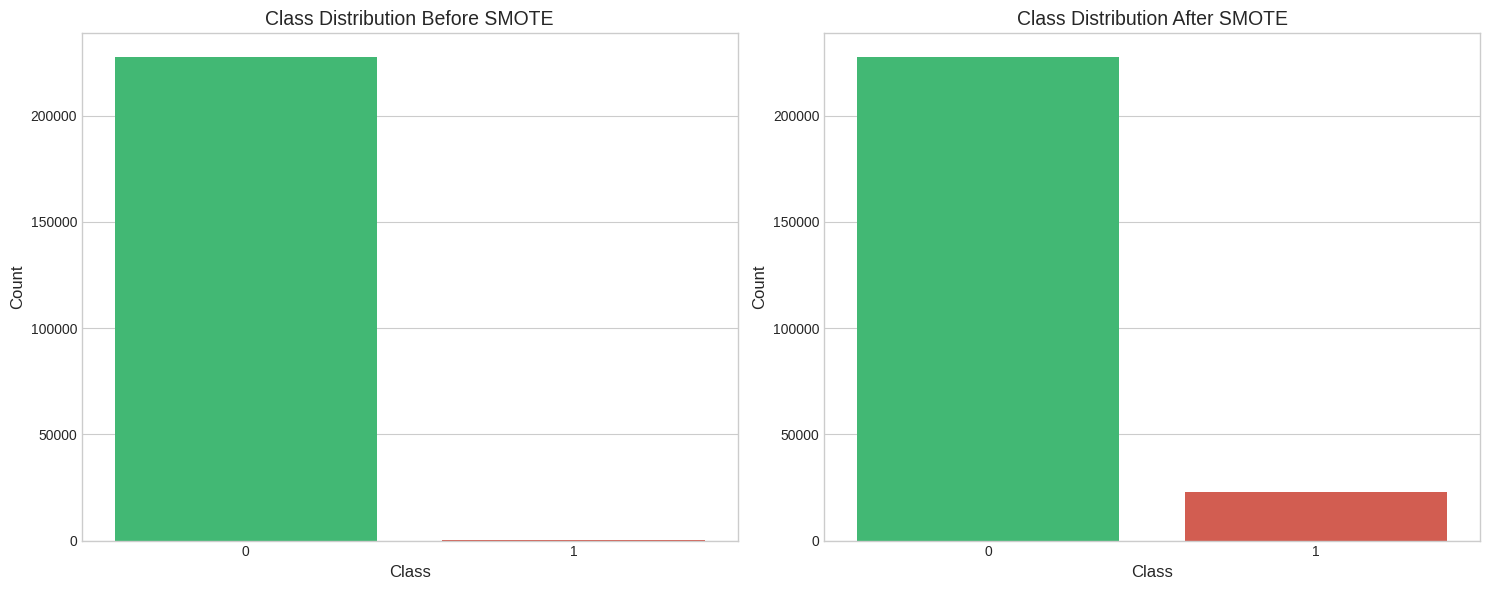

In [14]:
# Handle class imbalance using SMOTE
def handle_imbalance(X_train, y_train):
    """Handle class imbalance using SMOTE."""
    print("\nApplying SMOTE to handle class imbalance...")
    sm = SMOTE(random_state=42, sampling_strategy=0.1)  # 10% fraud examples
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    
    print(f"Original training set shape: {X_train.shape}")
    print(f"Resampled training set shape: {X_resampled.shape}")
    print(f"Original fraud percentage: {y_train.mean() * 100:.2f}%")
    print(f"Resampled fraud percentage: {y_resampled.mean() * 100:.2f}%")
    
    # Compare class distribution before and after resampling
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Before resampling
    sns.countplot(x=y_train, ax=ax[0], palette=['#2ecc71', '#e74c3c'])
    ax[0].set_title('Class Distribution Before SMOTE', fontsize=14)
    ax[0].set_xlabel('Class', fontsize=12)
    ax[0].set_ylabel('Count', fontsize=12)
    
    # After resampling
    sns.countplot(x=y_resampled, ax=ax[1], palette=['#2ecc71', '#e74c3c'])
    ax[1].set_title('Class Distribution After SMOTE', fontsize=14)
    ax[1].set_xlabel('Class', fontsize=12)
    ax[1].set_ylabel('Count', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return X_resampled, y_resampled

# Apply SMOTE
X_resampled, y_resampled = handle_imbalance(X_train, y_train)

# Train Models

In [15]:
# Train multiple models
def train_models(X_train, y_train):
    """Train multiple machine learning models."""
    print("\nTraining models...")
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(),
        'XGBoost': XGBClassifier(scale_pos_weight=10)
    }
    
    # Train each model
    trained_models = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model
    
    return trained_models

# Train the models
trained_models = train_models(X_resampled, y_resampled)


Training models...
Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...


# Evaluate Models

In [16]:
# Evaluate trained models
def evaluate_models(models, X_test, y_test):
    """Evaluate multiple machine learning models."""
    print("\nEvaluating models...")
    
    results = {}
    
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = y_pred
        
        # Calculate metrics
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_proba),
            'cm': confusion_matrix(y_test, y_pred),
            'y_proba': y_proba
        }
        
        print(f"Classification Report for {name}:")
        print(classification_report(y_test, y_pred))
    
    return results

# Evaluate the models
evaluation_results = evaluate_models(trained_models, X_test, y_test)


Evaluating models...

Evaluating Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


Evaluating Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.81      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Evaluating Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      1.00      

# Visualise Model Comparison


Model Performance Comparison:
                     Accuracy  Precision    Recall  F1 Score       AUC
Logistic Regression  0.974228   0.058065  0.918367  0.109223  0.968967
Random Forest        0.999456   0.868132  0.806122  0.835979  0.969471
Gradient Boosting    0.998244   0.494186  0.867347  0.629630  0.977671
XGBoost              0.999298   0.763636  0.857143  0.807692  0.979735


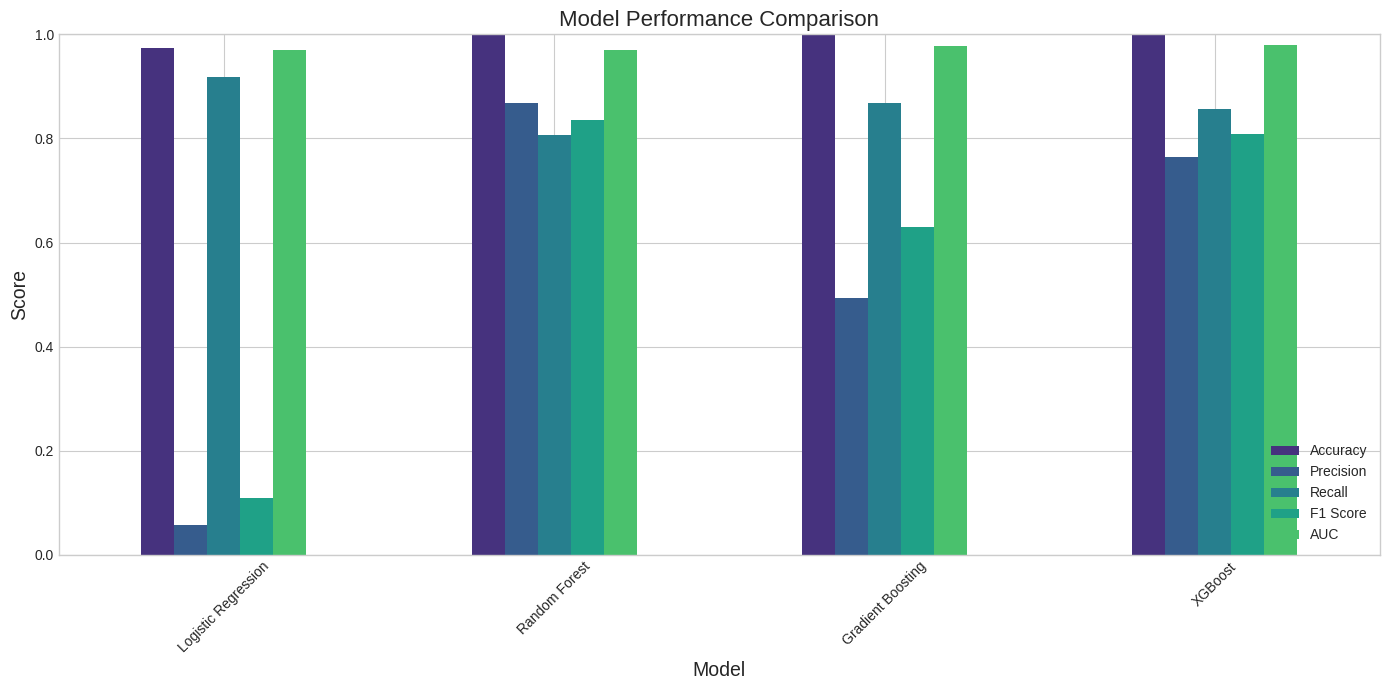

In [17]:
# Visualize model comparison
def visualize_results(results):
    """Create a comparison chart of model performance metrics."""
    metrics_df = pd.DataFrame({
        'Accuracy': [results[model]['accuracy'] for model in results],
        'Precision': [results[model]['precision'] for model in results],
        'Recall': [results[model]['recall'] for model in results],
        'F1 Score': [results[model]['f1'] for model in results],
        'AUC': [results[model]['auc'] for model in results]
    }, index=results.keys())
    
    print("\nModel Performance Comparison:")
    print(metrics_df)
    
    # Plot metrics comparison
    metrics_df.plot(kind='bar', figsize=(14, 7))
    plt.title('Model Performance Comparison', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    return metrics_df

# Visualize the results
metrics_df = visualize_results(evaluation_results)

# Plot ROC Curves

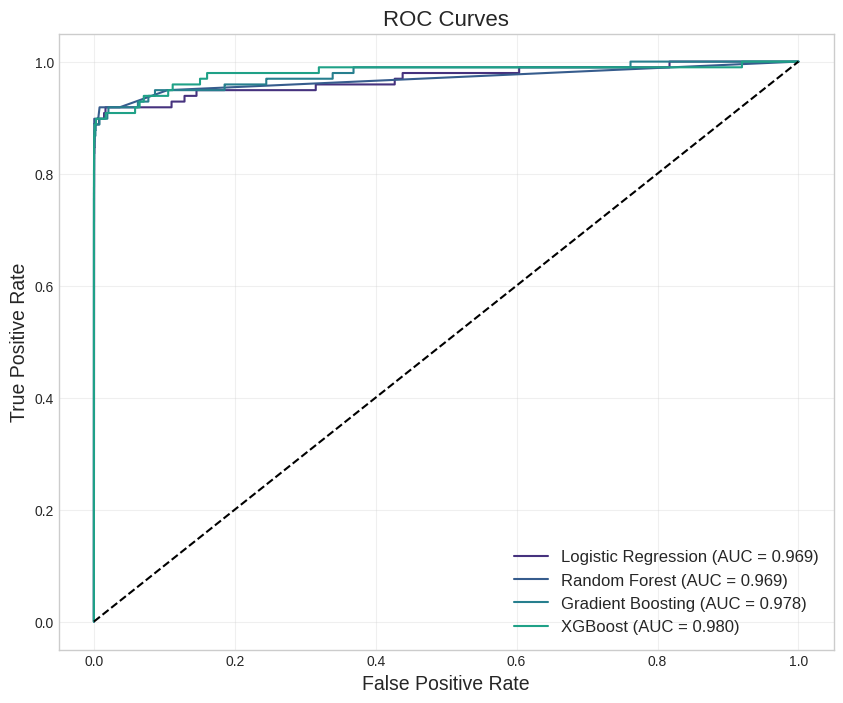

In [18]:
# Plot ROC curves
def plot_roc_curves(results, y_test):
    """Plot ROC curves for all models."""
    plt.figure(figsize=(10, 8))
    
    for name, metrics in results.items():
        fpr, tpr, _ = roc_curve(y_test, metrics['y_proba'])
        plt.plot(fpr, tpr, label=f"{name} (AUC = {metrics['auc']:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot ROC curves
plot_roc_curves(evaluation_results, y_test)

# Plot Confusion Matrices

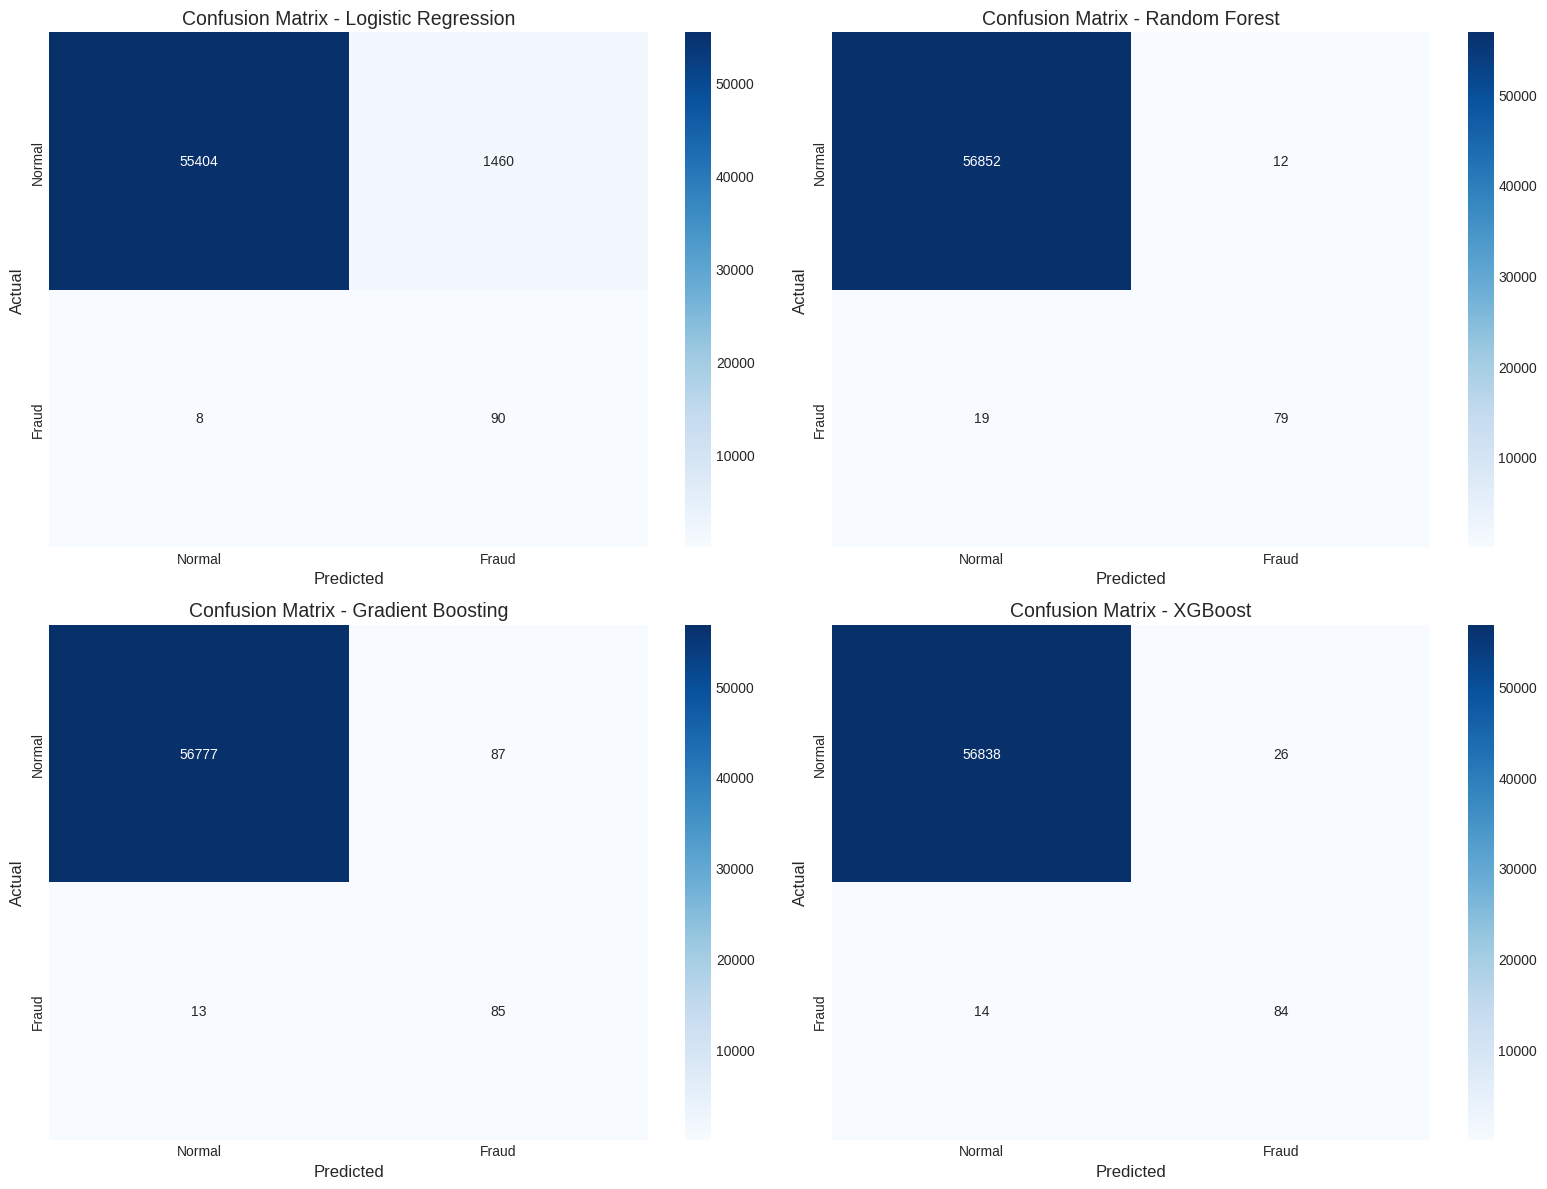

In [19]:
# Plot confusion matrices
def plot_confusion_matrices(results):
    """Plot confusion matrices for all models."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    for i, (name, metrics) in enumerate(results.items()):
        sns.heatmap(metrics['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
        axes[i].set_title(f'Confusion Matrix - {name}', fontsize=14)
        axes[i].set_xlabel('Predicted', fontsize=12)
        axes[i].set_ylabel('Actual', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(evaluation_results)

# Feature Importance Analysis

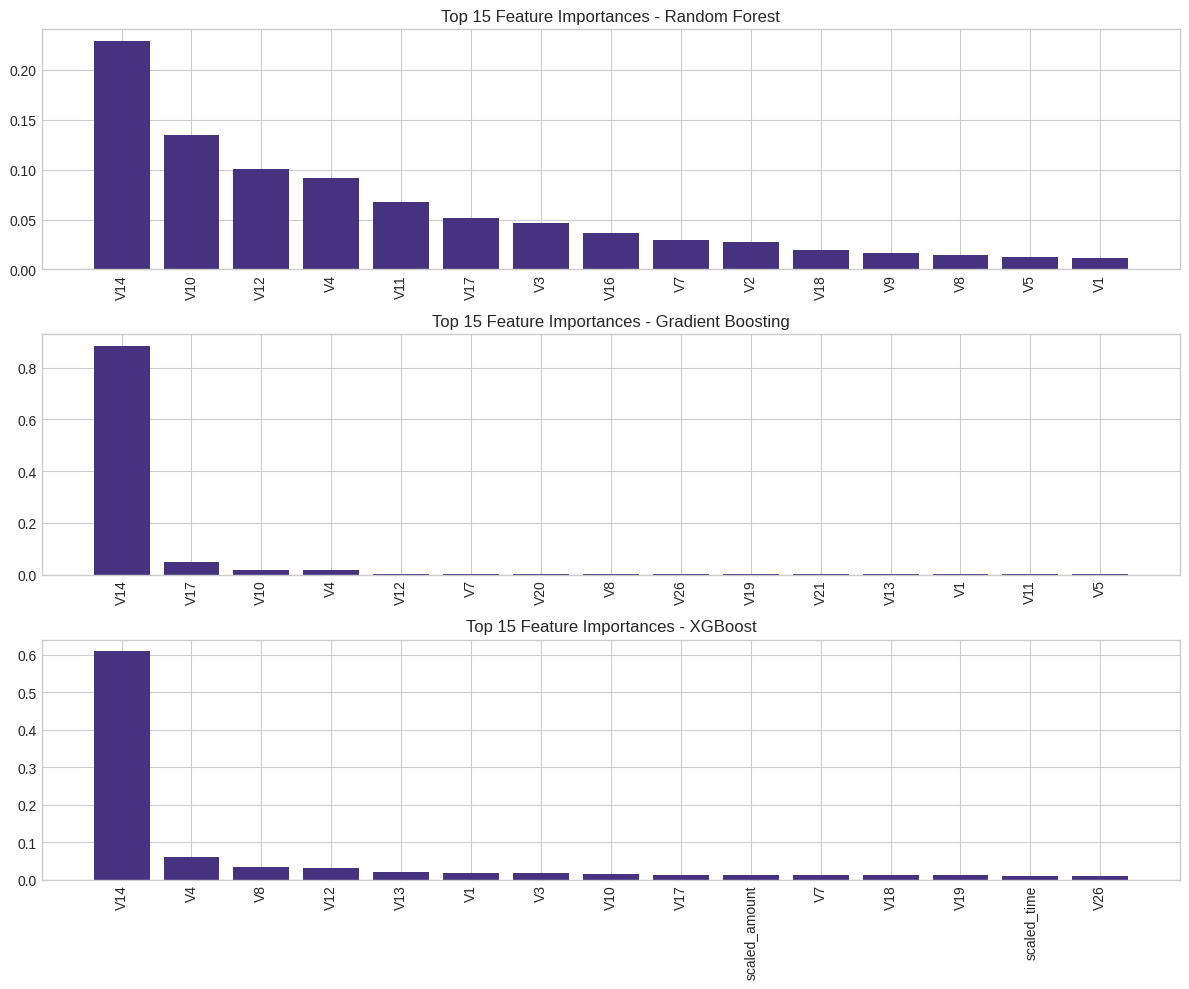

In [20]:
# Analyze feature importance
def feature_importance_analysis(models, X_test):
    """Analyze feature importance for tree-based models."""
    tree_models = {name: model for name, model in models.items() 
                 if hasattr(model, 'feature_importances_')}
    
    if not tree_models:
        print("No tree-based models to analyze feature importance.")
        return
    
    feature_names = X_test.columns
    
    plt.figure(figsize=(12, 10))
    
    for i, (name, model) in enumerate(tree_models.items()):
        # Get feature importances
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Plot the feature importances of the top 15 features
        plt.subplot(len(tree_models), 1, i + 1)
        plt.title(f"Top 15 Feature Importances - {name}")
        plt.bar(range(15), importances[indices][:15])
        plt.xticks(range(15), feature_names[indices][:15], rotation=90)
    
    plt.tight_layout()
    plt.show()

# Analyze feature importance
feature_importance_analysis(trained_models, X_test)

# Threshold Analysis for Best Model

Best model based on F1 score: Random Forest


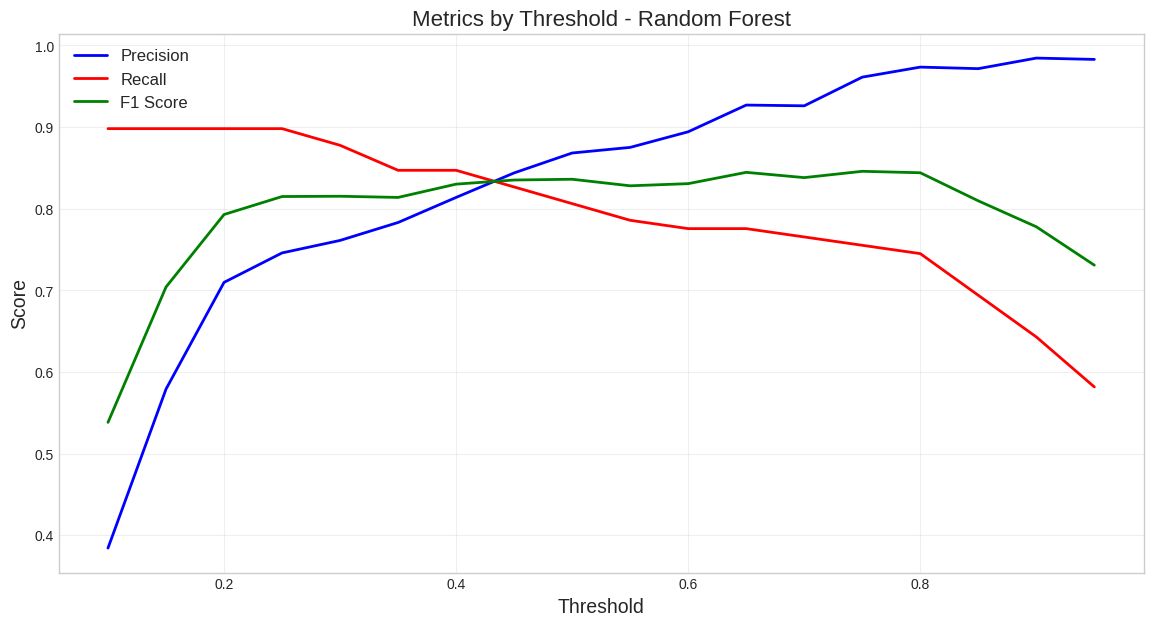


Optimal threshold for Random Forest: 0.75
Precision at optimal threshold: 0.9610
Recall at optimal threshold: 0.7551
F1 Score at optimal threshold: 0.8457


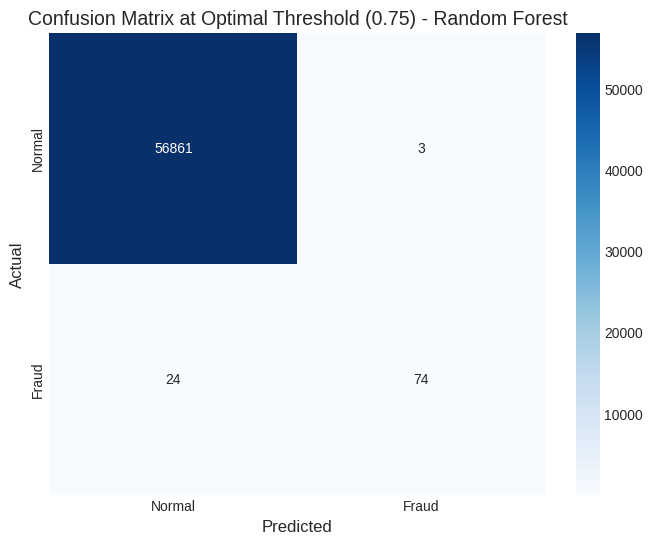

In [21]:
# Get the best model based on F1 score
best_model_name = metrics_df['F1 Score'].idxmax()
print(f"Best model based on F1 score: {best_model_name}")

# Analyze threshold impact for best model
def analyze_threshold_impact(model_name, results, y_test):
    """Analyze how different thresholds affect model performance."""
    y_proba = results[model_name]['y_proba']
    
    thresholds = np.arange(0.1, 1.0, 0.05)
    threshold_metrics = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        threshold_metrics.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    
    threshold_df = pd.DataFrame(threshold_metrics)
    
    plt.figure(figsize=(14, 7))
    plt.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', linewidth=2, label='Precision')
    plt.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', linewidth=2, label='Recall')
    plt.plot(threshold_df['threshold'], threshold_df['f1_score'], 'g-', linewidth=2, label='F1 Score')
    
    plt.title(f'Metrics by Threshold - {model_name}', fontsize=16)
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.show()
    
    # Find the optimal threshold for F1 score
    best_idx = threshold_df['f1_score'].idxmax()
    best_threshold = threshold_df.loc[best_idx, 'threshold']
    
    print(f"\nOptimal threshold for {model_name}: {best_threshold:.2f}")
    print(f"Precision at optimal threshold: {threshold_df.loc[best_idx, 'precision']:.4f}")
    print(f"Recall at optimal threshold: {threshold_df.loc[best_idx, 'recall']:.4f}")
    print(f"F1 Score at optimal threshold: {threshold_df.loc[best_idx, 'f1_score']:.4f}")
    
    # Show confusion matrix at optimal threshold
    y_pred_optimal = (y_proba >= best_threshold).astype(int)
    cm_optimal = confusion_matrix(y_test, y_pred_optimal)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
    plt.title(f'Confusion Matrix at Optimal Threshold ({best_threshold:.2f}) - {model_name}', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.show()
    
    return best_threshold

# Analyze threshold impact for the best model
optimal_threshold = analyze_threshold_impact(best_model_name, evaluation_results, y_test)

# Business Impact Analysis


Business Impact Analysis:
Detected Frauds: 74
Missed Frauds: 24
False Alarms: 3

Financial Impact:
Savings from Detected Frauds: $29,600.00
Cost of Missed Frauds: $9,600.00
Cost of Investigating False Alarms: $75.00
Cost of Investigating True Positives: $1,850.00
Net Savings: $27,675.00


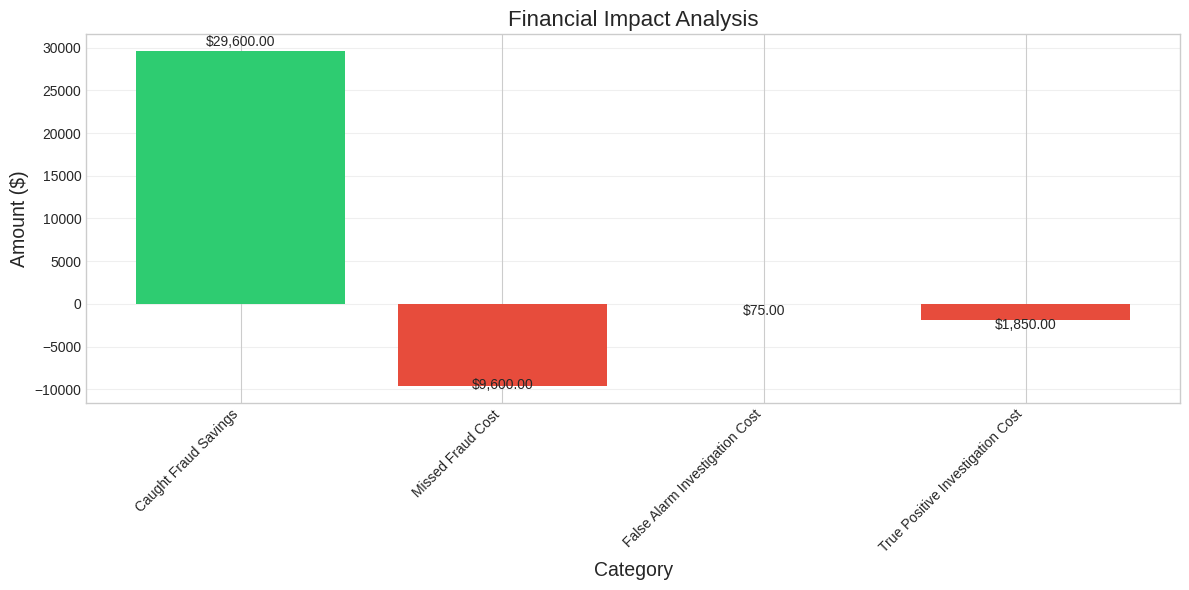

In [22]:
# Business impact analysis
def business_impact_analysis(model_name, results, y_test, threshold):
    """Analyze the business impact of the model."""
    # Make predictions using the optimal threshold
    y_proba = results[model_name]['y_proba']
    y_pred = (y_proba >= threshold).astype(int)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Business parameters
    # Note: These are hypothetical values used for illustration. In a production environment, these would be replaced with actual financial figures.
    avg_fraud_amount = 500  # Average amount of fraudulent transaction in $
    investigation_cost = 25  # Cost to investigate a transaction in $
    reimbursement_rate = 0.8  # Percentage of fraud amount reimbursed to customers
    
    # Calculate costs and savings
    missed_fraud_cost = fn * avg_fraud_amount * reimbursement_rate
    false_alarm_cost = fp * investigation_cost
    caught_fraud_savings = tp * avg_fraud_amount * reimbursement_rate
    investigation_cost_true_pos = tp * investigation_cost
    
    # Calculate net impact
    net_savings = caught_fraud_savings - false_alarm_cost - investigation_cost_true_pos
    
    print("\nBusiness Impact Analysis:")
    print(f"Detected Frauds: {tp}")
    print(f"Missed Frauds: {fn}")
    print(f"False Alarms: {fp}")
    
    print("\nFinancial Impact:")
    print(f"Savings from Detected Frauds: ${caught_fraud_savings:,.2f}")
    print(f"Cost of Missed Frauds: ${missed_fraud_cost:,.2f}")
    print(f"Cost of Investigating False Alarms: ${false_alarm_cost:,.2f}")
    print(f"Cost of Investigating True Positives: ${investigation_cost_true_pos:,.2f}")
    print(f"Net Savings: ${net_savings:,.2f}")
    
    # Create a bar chart of financial impact
    impact_data = {
        'Category': ['Caught Fraud Savings', 'Missed Fraud Cost', 
                    'False Alarm Investigation Cost', 'True Positive Investigation Cost'],
        'Amount': [caught_fraud_savings, -missed_fraud_cost, 
                  -false_alarm_cost, -investigation_cost_true_pos]
    }
    
    impact_df = pd.DataFrame(impact_data)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(impact_df['Category'], impact_df['Amount'], 
            color=['#2ecc71' if x > 0 else '#e74c3c' for x in impact_df['Amount']])
    
    plt.title('Financial Impact Analysis', fontsize=16)
    plt.xlabel('Category', fontsize=14)
    plt.ylabel('Amount ($)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 
                height * 1.01 if height > 0 else height * 0.9, 
                f'${abs(height):,.2f}', 
                ha='center', va='bottom' if height > 0 else 'top')
    
    plt.tight_layout()
    plt.show()

# Analyze business impact
business_impact_analysis(best_model_name, evaluation_results, y_test, optimal_threshold)